<a href="https://colab.research.google.com/github/appletreeleaf/Study_Log/blob/DL/%5BDL_HW5%5DLanguage_Model_%EC%9D%B4%EC%9E%AC%EC%98%81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **[HW5] Language Model**
1. DataLoader
2. Model
3. Trainer
4. Generation

이번 실습에서는 RNN기반의 Language Model를 구현해서 텍스트를 직접 생성해보는 실습을 진행해보겠습니다.

- dataset: WikiText2 (https://github.com/pytorch/examples/tree/master/word_language_model/data/wikitext-2)
- model: LSTM




## Import packages

런타임의 유형을 변경해줍니다.

상단 메뉴에서 [런타임]->[런타임유형변경]->[하드웨어가속기]->[GPU]

변경 이후 아래의 cell을 실행 시켰을 때, torch.cuda.is_avialable()이 True가 나와야 합니다.



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
print(torch.__version__)
print(torch.cuda.is_available())

1.13.1+cu116
True


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import tqdm
import os
import random
import time
import datetime

# for reproducibility
random.seed(1234)
np.random.seed(1234)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# 1. DataLoader

이전의 실습들에서 사용한것과 마찬가지로, PyTorch style의 dataloader를 먼저 만들어 두겠습니다.

### Dataset

저희가 이번 실습에서 사용할 데이터셋은 Wikipedia에 있는 영문 글들을 가져온 WikiTree dataset입니다.
저희가 불러올 데이터는 가장 작은 WikiTree dataset에서 자주 사용되지 않는 단어나 영어가 아닌 단어들은 <unk>으로 이미 전처리가 되어있습니다.

In [ ]:
import urllib
with urllib.request.urlopen('https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/02-intermediate/language_model/data/train.txt') as f:
    data = f.readlines()

In [ ]:
print('num_sentence:',len(data)) #42068개의 문장이 들어있다
data[100]

num_sentence: 42068


b" plans that give advertisers discounts for maintaining or increasing ad spending have become permanent <unk> at the news <unk> and underscore the fierce competition between newsweek time warner inc. 's time magazine and <unk> b. <unk> 's u.s. news & world report \n"

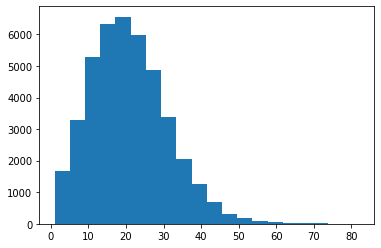

In [ ]:
seq_length_list = []
for line in data:
    seq_length_list.append(len(line.split())) # data에 있는 문장들을 split으로 쪼개서 문장들의 길이를 리스트에 추가함.

counts, bins = np.histogram(seq_length_list, bins=20)
plt.hist(bins[:-1], bins, weights=counts)
plt.show()

데이터에 있는 문장 길이들의 histogram을 볼 때 대부분의 data의 문장 길이가 50에 미치지 못하기 때문에 \\
model에 집어넣을 최대 문장 길이를 50으로 세팅해두도록 하겠습니다.

In [ ]:
max_seq_len = 50

### Build Dictionary

먼저 text 데이터를 모델에 넣어주기 위해서는 text에 존재하는 단어들을 index로 변환해주어야 합니다.

이를 위해서는 단어를 index로 변환해주는 word2idx dictionary와 다시 index를 단어로 변환해주는 idx2word dictionary를 만들어야 합니다.


In [ ]:
def build_dictionary(data, max_seq_len): # 단어를 index로 변환
    word2idx = {} # Empty dict / word to index
    idx2word = {} # Empty dict / index to word
    ## Build Dictionary
    word2idx['<pad>'] = 0
    word2idx['<unk>'] = 1
    idx2word[0] = '<pad>'
    idx2word[1] = '<unk>'
    idx = 2 # index 0은 <pad>, 1은 <unk>이므로 2부터 시작
    for line in data:
        words = line.decode('utf-8').split() # 단어를 문자열 단위로 쪼갬
        words = words[:max_seq_len]          # 문장길이를 50으로 제한
        ### Build Dictionary to convert word to index and index to word
        ### YOUR CODE HERE (~ 5 lines)
        for word in words:
            if word not in word2idx:
                word2idx[word] = idx # word to index
                idx2word[idx] = word # index to word
                idx += 1


    return word2idx, idx2word

word2idx, idx2word = build_dictionary(data, max_seq_len)

In [ ]:
if len(word2idx) == len(idx2word) == 10000: #중복이 없이 단어들을 dict로 만듬 // 두 dict의 길이가 같다
    print("Test Passed!")
else:
    raise AssertionError

Test Passed!


### Preprocessing

이제 앞서 만든 dictionary를 이용해서 text로된 데이터셋을 index들로 변환시키겠습니다.

In [ ]:
def preprocess(data, word2idx, idx2word, max_seq_len):
    tokens = []
    for line in data:
        words = line.decode('utf-8').split() #한 줄씩
        words = words[:max_seq_len] # 50개 까지 끊어어
        ### Convert dataset with tokens
        ### For each line, append <pad> token to match the number of max_seq_len
        ### YOUR CODE HERE (~ 4 lines)
        words += ['<pad>']*(max_seq_len - len(words)) # 50단어에 못미치는 문장들은 i, love, you, <pad>, <pad>... 이런식으로 길이를 50으로 맞춰줌
        for word in words:
            token = word2idx[word] # word to vector
            tokens.append(token) # encoding된 문장들을 모은 list

    return tokens

tokens = preprocess(data, word2idx, idx2word, max_seq_len)

In [ ]:
tokens

[2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 26,
 1,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 27,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 39,
 1,
 40,
 41,
 42,
 1,
 43,
 32,
 44,
 45,
 46,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 47,
 1,
 27,
 28,
 29,
 48,
 49,
 41,
 42,
 50,
 51,
 52,
 53,
 54,
 55,
 35,
 36,
 37,
 42,
 56,
 57,
 58,
 59,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 35,
 60,
 42,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 35,
 71,
 72,
 42,
 73,
 74,
 75,
 35,
 46,
 42,
 76,
 77,
 64,
 78,
 79,

In [ ]:
if len(tokens) == 2103400: #42068*50 -> 2103400*1 문장들을 일렬로 쭉 늘어놓은 길이
    print("Test Passed!")
else:
    raise AssertionError

Test Passed!


이제 전처리된 Token들을 문장 단위의 배열로 변환시켜 두겠습니다.

In [ ]:
tokens = np.array(tokens).reshape(-1, max_seq_len) # 열의 수를 max_seq_len=50으로 하고 행의 수는 자동으로 맞춰라
print(tokens.shape)
tokens[100]

(42068, 50)


array([745,  93, 746, 739, 747, 181, 748, 467, 749, 740, 750, 154, 751,
       752,   1, 160,  32, 753,   1,  48, 754,  32, 755, 756, 757, 728,
       555, 758,  99, 119, 555, 733,  48,   1, 759,   1, 119, 237, 753,
       230, 760, 347,   0,   0,   0,   0,   0,   0,   0,   0])

### DataLoader

이제 전처리된 dataset을 활용하여 PyTorch style의 dataset과 dataloader를 만들도록 하겠습니다.

Token형태의 데이터를 PyTorch 스타일의 dataset으로 만들 때 주의할 점은, 추후 embedding matrix에서 indexing을 해주기 위해서 각 token이 LongTensor 형태로 정의되어야 한다는 점입니다.

In [ ]:
class LMDataset(torch.utils.data.Dataset):
    def __init__(self, tokens):
        super(LMDataset, self).__init__()
        self.PAD = 0
        self.UNK = 1
        self.tokens = tokens
        self._getitem(2)

    def _getitem(self, index):
        X = self.tokens[index]
        y = np.concatenate((X[1:], [self.PAD])) # 왜 1부터 시작?

        X = torch.from_numpy(X).unsqueeze(0).long() # token to long shape
        y = torch.from_numpy(y).unsqueeze(0).long()

        return X, y

    def __getitem__(self, index):
        X = self.tokens[index]
        y = np.concatenate((X[1:], [self.PAD]))

        X = torch.from_numpy(X).long()
        y = torch.from_numpy(y).long()

        return X, y

    def __len__(self):
        return len(self.tokens)

In [ ]:
batch_size = 64 #전체 데이터를 64개씩 묶어서 학습하겠다다
dataset = LMDataset(tokens) # PyTorch 스타일로 변경
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True) # shuffle은 1 epochs마다 데이터를 섞겠다.

print(len(dataset))
print(len(dataloader))

42068
658


# 2. Model

이번 section에서는 Language Modeling을 위한 Recurrent Model을 직접 만들어보도록 하겠습니다.

Standard한 Recurrent Neural Network (RNN) model은 vanishing gradient 문제에 취약하기 때문에, 이번 실습에서는 변형된 RNN구조인 LSTM model을 활용하도록 하겠습니다.


### LSTM

LSTM model의 전체적인 구조와 각 gate의 수식은 아래와 같습니다.

![](https://drive.google.com/uc?export=view&id=1n93tpNW55Xl4GxZNcJcbUVRhuNCGH38h)

![](https://drive.google.com/uc?export=view&id=1nH9U5iD9cO6OVVTbrx-LjypRvcWzbOCU)

LSTM의 자세한 동작방식이 궁금하신 분은 아래의 블로그를 참조해주세요.

https://colah.github.io/posts/2015-08-Understanding-LSTMs/

In [ ]:
class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTMCell, self).__init__()
        # input-gate : 새로운 정보의 반영비
        self.Wi = nn.Linear(input_size + hidden_size, hidden_size)
        # forget-gate : 이전 메모리 중 불필요한 부분 제거
        self.Wf = nn.Linear(input_size + hidden_size, hidden_size)
        # gate-gate : 현재 단계에서 새로운 정보 생성
        self.Wg = nn.Linear(input_size + hidden_size, hidden_size)
        # output-gate : 이전 상태의 출력량
        self.Wo = nn.Linear(input_size + hidden_size, hidden_size)

        # non-linearity
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()

    def forward(self, x, h_0, c_0):
        """
        Inputs
            input (x): [batch_size, input_size]
            hidden_state (h_0): [batch_size, hidden_size]
            cell_state (c_0): [batch_size, hidden_size]
        Outputs
            next_hidden_state (h_1): [batch_size, hidden_size]
            next_cell_state (c_1): [batch_size, hidden_size]
        """
        h_1, c_1 = None, None
        input = torch.cat((x, h_0), 1) # ((input_data, prev_hidden state), c_0)
        # Implement LSTM cell as noted above
        ### YOUR CODE HERE (~ 6 lines)
        i = self.sigmoid(self.Wi(input))
        f = self.sigmoid(self.Wf(input))
        g = self.tanh(self.Wg(input))
        o = self.sigmoid(self.Wo(input))
        c_1 = f * c_0 + i * g
        h_1 = o * self.tanh(c_1)

        return h_1, c_1

In [ ]:
def test_lstm():
    batch_size = 2
    input_size = 5
    hidden_size = 3

    #torch.manual_seed(1234)
    lstm = LSTMCell(input_size ,hidden_size)
    def init_weights(m):
        if isinstance(m, nn.Linear):
            torch.nn.init.constant_(m.weight, 0.1)
            m.bias.data.fill_(0.01)
    lstm.apply(init_weights)

    x = torch.ones(batch_size, input_size)    # input
    hx = torch.zeros(batch_size, hidden_size) # hidden state
    cx = torch.zeros(batch_size, hidden_size) # cell

    hx, cx = lstm(x, hx, cx) # lstm을 적용시킨 후의 hx, cx
    assert hx.detach().allclose(torch.tensor([[0.1784, 0.1784, 0.1784],
                                              [0.1784, 0.1784, 0.1784]]), atol=2e-1), \
            f"Output of the hidden state does not match."
    assert cx.detach().allclose(torch.tensor([[0.2936, 0.2936, 0.2936],
                                              [0.2936, 0.2936, 0.2936]]), atol=2e-1), \
            f"Output of the cell state does not match."

    print("==LSTM cell test passed!==")

test_lstm()

==LSTM cell test passed!==


## Language Model

이제, 위에서 정의한 LSTM Cell을 활용해서 아래와 같은 Langauge Model을 만들어보도록 하겠습니다.


![](https://drive.google.com/uc?export=view&id=1nMAbL-g31nERM44dgohA3k9Vj_92hIh-)

In [ ]:
class LanguageModel(nn.Module):
    def __init__(self, input_size=64, hidden_size=64, vocab_size=10000):
        super(LanguageModel, self).__init__() #왜 선언하는지 모르겠다.

        self.input_layer = nn.Embedding(vocab_size, input_size) # word -> inteager -> look-up table(여기서 word2ix ?)/ 해당정수를 인덱스로 갖는 벡터 반환 -> 인풋 벡터가 된다.
        self.hidden_layer = LSTMCell(input_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, vocab_size)


    def forward(self, x, hx, cx, predict=False):
        """
        Inputs
            input (x): [batch_size]
            hidden_state (h_0): [batch_size, hidden_size]
            cell_state (c_0): [batch_size, hidden_size]
            predict: whether to predict and sample the next word
        Outputs
            output (ox): [batch_size, hidden_size]
            next_hidden_state (h_1): [batch_size, hidden_size]
            next_cell_state (c_1): [batch_size, hidden_size]
        """
        x = self.input_layer(x)
        hx, cx = self.hidden_layer(x, hx, cx)
        ox = self.output_layer(hx)

        if predict == True:
            probs = F.softmax(ox, dim=1) # softmax a1
            # torch distribution allows sampling operation
            # see https://pytorch.org/docs/stable/distributions.html
            dist = torch.distributions.Categorical(probs)
            ox = dist.sample()

        return ox, hx, cx

# 3. Trainer

자 이제 위에서 구현한 dataloader와 langauge model을 활용해서 모델의 학습을 진행해보도록 하겠습니다.


In [ ]:
class Trainer():
    def __init__(self,
                 word2idx,
                 idx2word,
                 dataloader,
                 model,
                 criterion,
                 optimizer,
                 device):
        """
        dataloader: dataloader
        model: langauge model
        criterion: loss function to evaluate the model (e.g., BCE Loss)
        optimizer: optimizer for model
        """
        self.word2idx = word2idx
        self.idx2word = idx2word
        self.dataloader = dataloader
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device

    def train(self, epochs = 1):
        self.model.to(self.device) # transfer gpu
        start_time = time.time()
        for epoch in range(epochs):
            losses = []
            for iter, (x_batch, y_batch) in tqdm.tqdm(enumerate(self.dataloader)):
                self.model.train()

                batch_size, max_seq_len = x_batch.shape
                x_batch = x_batch.to(self.device)
                y_batch = y_batch.to(self.device)

                # initial hidden-states
                hx = torch.zeros(batch_size, hidden_size).to(self.device)
                cx = torch.zeros(batch_size, hidden_size).to(self.device)

                # Implement LSTM operation
                ox_batch = []
                # Get output logits for each time sequence and append to the list, ox_batch
                # YOUR CODE HERE (~ 4 lines)
                for s_idx in range(max_seq_len):
                    x = x_batch[:, s_idx]
                    ox, hx, cx = self.model(x, hx, cx)
                    ox_batch.append(ox)
                # outputs are ordered by the time sequence
                ox_batch = torch.cat(ox_batch).reshape(max_seq_len, batch_size, -1)
                ox_batch = ox_batch.permute(1,0,2).reshape(batch_size*max_seq_len, -1)
                y_batch = y_batch.reshape(-1)

                self.model.zero_grad()
                loss = self.criterion(ox_batch, y_batch)
                loss.backward()
                self.optimizer.step()
                losses.append(loss.item())

            end_time = time.time() - start_time
            end_time = str(datetime.timedelta(seconds=end_time))[:-7]
            print('Time [%s], Epoch [%d/%d], loss: %.4f'
                  % (end_time, epoch+1, epochs, np.mean(losses)))
            if epoch % 5 == 0:
                generated_sentences = self.test()
                print('[Generated Sentences]')
                for sentence in generated_sentences:
                    print(sentence)

    def test(self):
        # Test model to genereate the sentences
        self.model.eval()
        num_sentence = 5
        max_seq_len = 50

        # initial hidden-states
        outs = []
        x = torch.randint(0, 10000, (num_sentence,)).to(self.device)
        hx = torch.zeros(num_sentence, hidden_size).to(self.device)
        cx = torch.zeros(num_sentence, hidden_size).to(self.device)

        outs.append(x)
        with torch.no_grad():
            for s_idx in range(max_seq_len-1):
                x, hx, cx = self.model(x, hx, cx, predict=True)
                outs.append(x)
        outs = torch.cat(outs).reshape(max_seq_len, num_sentence)
        outs = outs.permute(1, 0)
        outs = outs.detach().cpu().numpy()

        sentences = []
        for out in outs:
            sentence = []
            for token_idx in out:
                word = self.idx2word[token_idx]
                sentence.append(word)
            sentences.append(sentence)

        return sentences

In [ ]:
for iter,(x_batch,y_batch) in (enumerate(dataloader)):
    print(x_batch.shape)

torch.Size([256, 50])
torch.Size([256, 50])
torch.Size([256, 50])
torch.Size([256, 50])
torch.Size([256, 50])
torch.Size([256, 50])
torch.Size([256, 50])
torch.Size([256, 50])
torch.Size([256, 50])
torch.Size([256, 50])
torch.Size([256, 50])
torch.Size([256, 50])
torch.Size([256, 50])
torch.Size([256, 50])
torch.Size([256, 50])
torch.Size([256, 50])
torch.Size([256, 50])
torch.Size([256, 50])
torch.Size([256, 50])
torch.Size([256, 50])
torch.Size([256, 50])
torch.Size([256, 50])
torch.Size([256, 50])
torch.Size([256, 50])
torch.Size([256, 50])
torch.Size([256, 50])
torch.Size([256, 50])
torch.Size([256, 50])
torch.Size([256, 50])
torch.Size([256, 50])
torch.Size([256, 50])
torch.Size([256, 50])
torch.Size([256, 50])
torch.Size([256, 50])
torch.Size([256, 50])
torch.Size([256, 50])
torch.Size([256, 50])
torch.Size([256, 50])
torch.Size([256, 50])
torch.Size([256, 50])
torch.Size([256, 50])
torch.Size([256, 50])
torch.Size([256, 50])
torch.Size([256, 50])
torch.Size([256, 50])
torch.Size

In [ ]:
lr = 1e-2
input_size = 128
hidden_size = 128
batch_size = 256

dataset = LMDataset(tokens)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
model = LanguageModel(input_size=input_size, hidden_size=hidden_size)
# NOTE: you should use ignore_index to ignore the loss from predicting the <PAD> token
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters(), lr=lr)
device = torch.device('cuda')

trainer = Trainer(word2idx = word2idx,
                  idx2word = idx2word,
                  dataloader=dataloader,
                  model = model,
                  criterion=criterion,
                  optimizer = optimizer,
                  device=device)

trainer.train(epochs=50)

165it [00:15, 10.47it/s]


Time [0:00:15], Epoch [1/50], loss: 6.0491
[Generated Sentences]
['underscore', 'drinking', 'than', 'yesterday', 'said', 'it', 'was', 'up', 'residents', 'and', 'on', 'britain', 'said', 'that', 'the', 'agreement', '<unk>', 'treatment', 'when', 'uncertainty', 'for', 'precisely', '$', 'N', 'on', 'N', 'billion', 'nyse', 'began', 'a', '$', 'N', 'million', 'charge', 'of', 'the', 'last', 'raising', 'great', 'include', 'broader', 'agreement', 'and', 'frustrated', 'than', 'N', 'N', 'more', 'issued', 'in']
['foam', 'leave', 'dollars', 'in', 'a', 'board', 'area', 'and', 'el', 'institutional', 'high', 'interest', 'figures', 'are', 'dragged', 'right', 'small', 'money', 'of', 'these', 'states', 'of', 'looking', 'than', 'mr.', 'antar', 'also', 'expects', 'a', 'loss', 'from', 'steven', '<unk>', 'parental', 'prices', 'or', 'summoned', '<unk>', '<unk>', 'to', 'consider', 'how', 'pulls', 'just', 'an', 'boston', '<unk>', 'plants', 'to', 'withdraw']
['palo', 'nights', 'have', "n't", 'been', 'hanging', 'dir

165it [00:16, 10.29it/s]


Time [0:00:31], Epoch [2/50], loss: 5.2110


165it [00:15, 10.46it/s]


Time [0:00:47], Epoch [3/50], loss: 4.8978


165it [00:15, 10.51it/s]


Time [0:01:03], Epoch [4/50], loss: 4.6893


165it [00:15, 10.32it/s]


Time [0:01:19], Epoch [5/50], loss: 4.5314


165it [00:15, 10.50it/s]


Time [0:01:35], Epoch [6/50], loss: 4.4050
[Generated Sentences]
['bets', 'parity', 'publicity', 'problems', 'at', 'eastern', "'s", 'new', 'declined', 'to', 'hold', 'a', 'record', 'for', '$', 'N', 'to', '$', 'N', 'million', 'from', '$', 'N', 'million', 'to', '$', 'N', 'million', 'or', 'N', 'cents', 'to', '$', 'N', 'million', 'or', 'so', 'change', 'the', 'difference', 'between', 'third-quarter', 'earnings', 'hurt', '$', 'N', 'billion', 'in', 'third-quarter', 'level']
['unexpectedly', '<unk>', 'the', 'ems', 'might', 'not', 'it', 'is', 'heavily', 'with', 'india', 'highway', 'offices', 'in', 'N', 'and', '<unk>', 'in', '<unk>', 'to', 'kill', 'other', 'areas', 'such', 'as', 'independent', 'directors', 'further', 'promoting', '<unk>', 'intensive', 'exports', 'increased', 'in', 'the', 'week', 'after', 'buying', 'N', 'N', 'of', 'term', 'to', 'early', 'selling', 'prices', 'of', 'attention', 'to', '$']
['rule', 'batibot', 'should', 'find', 'american', '<unk>', 'information', 'for', 'not', '<unk>'

165it [00:18,  9.04it/s]


Time [0:01:53], Epoch [7/50], loss: 4.2975


165it [00:16, 10.17it/s]


Time [0:02:09], Epoch [8/50], loss: 4.2074


165it [00:15, 10.40it/s]


Time [0:02:25], Epoch [9/50], loss: 4.1263


165it [00:15, 10.55it/s]


Time [0:02:41], Epoch [10/50], loss: 4.0564


165it [00:15, 10.45it/s]


Time [0:02:56], Epoch [11/50], loss: 3.9931
[Generated Sentences]
['cases', 'always', 'saying', 'that', 'price', 'declines', 'from', 'its', 'session', 'in', 'the', 'august', 'on', 'six-month', 'cds', 'do', 'are', 'falling', 'because', 'of', 'revenue', 'would', 'be', 'received', 'by', 'the', 'alternative', 'rep.', 'john', 'pope', 'slipped', 'to', '$', 'N', 'million', 'or', '$', 'N', 'a', 'share', 'or', '$', 'N', 'a', 'share', 'or', 'N', 'cents', 'a', 'share']
['division', 'major', 'prices', 'fell', 'slightly', 'to', 'the', 'N', 'N', 'jump', 'in', 'a', 'pretax', 'charge', 'of', '$', 'N', 'million', 'and', 'honeywell', 'to', 'buy', 'a', '$', 'N', 'billion', 'amount', 'from', 'a', 'year', 'ago', 'but', 'worries', 'that', 'the', 'most', 'dramatic', 'situation', 'would', 'take', 'several', 'quarters', 'of', '<unk>', 'will', 'register', 'line', 'with', 'profits', 'in']
['spoken', 'implicit', 'he', 'says', 'the', '<unk>', 'dam', 'would', 'completely', 'disrupt', 'access', 'to', 'this', 'week',

165it [00:16, 10.16it/s]


Time [0:03:13], Epoch [12/50], loss: 3.9379


165it [00:16, 10.25it/s]


Time [0:03:29], Epoch [13/50], loss: 3.8856


165it [00:16, 10.11it/s]


Time [0:03:45], Epoch [14/50], loss: 3.8401


165it [00:16, 10.15it/s]


Time [0:04:01], Epoch [15/50], loss: 3.7965


165it [00:15, 10.45it/s]


Time [0:04:17], Epoch [16/50], loss: 3.7590
[Generated Sentences]
['record', 'dates', 'shot', 'of', 'mistakenly', 'partly', 'offset', 'by', 'that', '<unk>', 'weekend', 'that', 'are', 'giving', 'warner', 'moves', 'if', 'economic', 'outlook', 'is', 'limited', 'and', 'i', 'ca', "n't", 'do', 'so', 'today', 'a', 'way', 'that', 'new', 'york', "'s", 'backing', 'there', 'are', 'vice', 'president', 'and', 'his', 'institute', 'for', 'president', '<unk>', 'and', 'symptoms', 'in', 'areas', 'charging']
['equivalent', 'archrival', 'trans', 'nations', 'seek', 'a', 'lawsuit', 'represented', 'by', 'N', 'N', 'of', 'the', 'partnership', "'s", 'first', 'boston', 'service', 'and', '<unk>', 'countries', 'in', 'january', 'N', 'for', 'one', 'share', 'of', 'bethlehem', 'and', 'to', 'remain', 'independent', 'and', 'misleading', 'statements', 'over', 'the', 'foreign', 'purchasing', 'managers', 'index', 'and', 'buyers', 'shares', 'by', 'buying', 'foreign', 'ownership', 'banks']
['parade', 'addition', 'to', 'the',

165it [00:15, 10.50it/s]


Time [0:04:33], Epoch [17/50], loss: 3.7225


165it [00:16, 10.30it/s]


Time [0:04:49], Epoch [18/50], loss: 3.6923


165it [00:15, 10.38it/s]


Time [0:05:05], Epoch [19/50], loss: 3.6636


165it [00:15, 10.44it/s]


Time [0:05:21], Epoch [20/50], loss: 3.6371


165it [00:15, 10.49it/s]


Time [0:05:36], Epoch [21/50], loss: 3.6098
[Generated Sentences]
['toshiba', 'corp.', 'has', "n't", 'presented', 'a', 'new', 'structure', 'to', 'be', 'more', '<unk>', 'and', 'fiercely', 'attention', 'to', 'the', 'nation', "'s", 'merchandise', 'that', 'will', 'come', 'down', 'on', 'the', '<unk>', '<unk>', 'of', 'its', '<unk>', 'that', 'he', 'previously', 'ordered', 'whether', 'you', 'are', 'signs', 'by', 'portraying', 'itself', 'to', '<unk>', 'the', '<unk>', 'of', 'the', 'voice', 'of']
['prosecutor', 'at', 'this', 'level', 'does', 'they', 'have', 'to', 'come', 'up', 'to', 'a', 'picture', 'to', 'magnetic', 'stimulators', 'in', 'the', 'elections', 'over', 'his', 'shoulder', 'from', '<unk>', 'this', 'industry', 'organization', 'and', 'northeast', 'bancorp', 'with', 'assurance', 'displays', 'from', 'singapore', 'said', 'it', 'would', 'pay', 'claims', 'from', 'sunnyvale', 'to', 'be', 'fully', 'operational', 'by', 'an', '<unk>', 'with']
['downgraded', 'by', 'sen.', 'mitchell', 'a', 'securiti

165it [00:15, 10.41it/s]


Time [0:05:52], Epoch [22/50], loss: 3.5874


165it [00:15, 10.41it/s]


Time [0:06:08], Epoch [23/50], loss: 3.5647


165it [00:15, 10.50it/s]


Time [0:06:24], Epoch [24/50], loss: 3.5432


165it [00:15, 10.33it/s]


Time [0:06:40], Epoch [25/50], loss: 3.5265


165it [00:15, 10.49it/s]


Time [0:06:56], Epoch [26/50], loss: 3.5114
[Generated Sentences]
['guard', 'feared', 'who', 'had', 'made', 'the', 'right', 'to', '<unk>', 'its', 'power', 'to', 'protect', 'alcohol', 'subsidies', 'for', 'a', 'single', 'exception', 'earlier', 'this', 'year', 'as', 'the', 'labor', '<unk>', 'of', 'the', 'economy', 'and', '<unk>', 'of', 'the', 'security', 'of', '<unk>', 'management', 'and', 'walter', 'law', 'mr.', 'lang', 'pumped', '$', 'N', 'right', 'to', 'pay', 'the', 'power']
['spending', 'average', 'weekend', 'another', 'thrift', 'rights', 'spend', '$', 'N', 'million', 'of', 'tax', 'debt', 'of', '$', 'N', 'million', 'per', 'share', 'of', 'N', 'N', 'N', 'secured', 'liabilities', 'tuesday', 'while', 'N', 'N', 'and', 'N', 'N', 'stakes', 'in', '<unk>', 'laser', 'disks', 'and', 'chemical', 'industries', 'inc.', 'citing', 'cost-cutting', 'auto', 'maker', 'and', '<unk>', 'corp.', 'and', 'to']
['strengthening', 'examine', 'horrible', 'holdings', 'using', 'environmental', 'litigation', 'aim', '

165it [00:15, 10.50it/s]


Time [0:07:11], Epoch [27/50], loss: 3.4940


165it [00:16, 10.10it/s]


Time [0:07:28], Epoch [28/50], loss: 3.4779


165it [00:15, 10.44it/s]


Time [0:07:44], Epoch [29/50], loss: 3.4647


165it [00:15, 10.55it/s]


Time [0:07:59], Epoch [30/50], loss: 3.4499


165it [00:15, 10.47it/s]


Time [0:08:15], Epoch [31/50], loss: 3.4388
[Generated Sentences]
['fails', 'financially', 'it', 'is', 'involved', 'in', 'the', 'agreement', 'showing', 'the', 'white', 'house', 'on', 'federal', 'banks', 'that', 'will', 'restrict', 'the', 'extra', 'doctor', 'of', 'finding', '<unk>', 'at', 'productivity', "'s", 'declines', 'in', 'his', 'european', 'office', 'supply', 'before', 'they', 'buy', 'apples', 'and', 'failed', 'to', 'stay', '<unk>', 'where', 'she', 'was', 'sparked', 'by', 'an', '<unk>', '<unk>']
['shouted', 'assumes', 'the', 'key', 'department', 'is', 'insured', 'because', 'of', 'weakness', 'in', 'the', 'coffee', 'business', 'this', 'fiscal', 'year', 'by', 'the', 'end', 'of', 'this', 'month', "'s", 'N', 'million', 'soviet', 'number', 'for', 'new', 'interest-rate', 'equivalent', 'of', '<unk>', 'strategies', '<unk>', 'sport', 'utility', 'hands', 'american', 'companies', 'in', 'the', 'west', 'of', 'international', 'areas', 'membership', 'in', 'joining']
['dividends', 'journalists', 

165it [00:16, 10.31it/s]


Time [0:08:31], Epoch [32/50], loss: 3.4275


165it [00:15, 10.43it/s]


Time [0:08:47], Epoch [33/50], loss: 3.4188


165it [00:15, 10.48it/s]


Time [0:09:03], Epoch [34/50], loss: 3.4072


165it [00:15, 10.42it/s]


Time [0:09:18], Epoch [35/50], loss: 3.3980


165it [00:15, 10.52it/s]


Time [0:09:34], Epoch [36/50], loss: 3.3888
[Generated Sentences]
['roebuck', 'technologies', 'inc.', 'said', 'the', 'suitor', 'schools', 'are', 'to', 'be', '<unk>', 'before', 'a', 'half-hour', 'rating', 'in', 'the', 'u.s.', 'with', 'cold', 'fusion', 'experiments', 'including', 'a', 'reluctant', 'witness', 'for', 'a', 'circuit', 'breaker', 'process', 'for', 'certain', 'drug-related', '<unk>', 'and', 'filled', 'with', 'the', '<unk>', 'institute', 'of', 'america', 'police', 'reported', 'that', 'investors', 'will', 'a', 'growing']
['p&g', 'that', 'accounts', 'take', 'charge', 'of', 'our', 'own', 'over', 'the', 'world', 'bank', 'and', 'aerospace', 'concern', 'succeeding', 'chairman', 'breeden', 'said', 'his', 'son', 'would', 'head', 'the', 'economic', '<unk>', 'and', 'in', 'obtaining', 'one', 'hand', 'it', 'says', 'standard', '&', 'poor', "'s", 'corp.', 'all', 'join', '<unk>', 'pilots', 'will', 'receive', '$', 'N', 'but', 'were', "n't", 'clear']
['abramson', 'mandate', 'from', 'deposits', 

165it [00:15, 10.51it/s]


Time [0:09:50], Epoch [37/50], loss: 3.3840


165it [00:15, 10.58it/s]


Time [0:10:06], Epoch [38/50], loss: 3.3730


165it [00:15, 10.35it/s]


Time [0:10:21], Epoch [39/50], loss: 3.3674


165it [00:15, 10.59it/s]


Time [0:10:37], Epoch [40/50], loss: 3.3578


165it [00:15, 10.61it/s]


Time [0:10:53], Epoch [41/50], loss: 3.3503
[Generated Sentences]
['hope', 'who', 'are', 'wooden', 'equal', 'old', 'this', 'farmer', 'of', 'the', 'tank', 'in', '<unk>', 'capital', 'insight', 'inc.', '<unk>', 'the', 'orange', 'workers', 'for', 'corporations', "'", 'results', 'out', 'of', 'by', 'congress', 'rep.', 'bush', 'rejected', 'a', 'reputation', 'for', 'the', 'remaining', 'reliance', 'collection', 'agencies', 'are', 'and', 'the', 'flat', 'surface', 'where', 'he', 'has', 'an', 'enormous', '<unk>']
['accused', 'congress', 'had', 'been', 'transformed', 'from', 'trails', 'pepsi', 'in', 'the', 'california', 'supreme', 'court', '<unk>', 'a', 'panamanian', 'diplomat', 'based', 'in', 'peru', 'named', 'luis', '&', 'telegraph', 'co.', 'and', 'dallas', 'says', 'he', 'hopes', 'all', 'of', 'these', 'numbers', 'wo', "n't", 'indicate', 'the', 'official', 'and', 'southeast', 'asian', 'trade', 'figures', 'without', 'excluding', 'bad', 'loan', 'price', 'for']
['cities', 'competent', 'a', 'group', '

165it [00:15, 10.35it/s]


Time [0:11:09], Epoch [42/50], loss: 3.3445


165it [00:15, 10.49it/s]


Time [0:11:24], Epoch [43/50], loss: 3.3413


165it [00:15, 10.34it/s]


Time [0:11:40], Epoch [44/50], loss: 3.3407


165it [00:15, 10.63it/s]


Time [0:11:56], Epoch [45/50], loss: 3.3311


165it [00:15, 10.40it/s]


Time [0:12:12], Epoch [46/50], loss: 3.3250
[Generated Sentences]
['accessories', 'reason', 'lately', 'rampant', 'tom', '<unk>', 'suggested', 'that', 'kind', 'of', 'philosophy', 'programming', 'a', 'loose', 'state', 'court', 'complaining', 'that', 'they', 'would', 'find', 'action', 'in', 'the', 'country', 'that', 'are', 'often', 'protected', 'by', 'the', 'author', "'s", 'initiative', 'passed', 'in', 'another', 'important', 'ban', 'on', 'market', 'movements', 'curb', 'imports', 'appeal', 'were', 'common', 'along', 'says', 'mr.']
['amoco', "'s", 'estimated', 'current', 'price', 'and', 'provide', 'a', 'c', 'investment', 'crop', 'in', 'the', 'mid-1970s', 'what', 'happens', 'because', 'it', 'just', 'two', 'is', "n't", 'a', 'lot', 'of', 'the', 'market', 'through', 'a', 'cd', 'following', 'an', 'new', 'zealand', 'government', 'of', 'N', 'employees', 'surveyed', 'are', "n't", 'being', 'made', 'available', 'systems', 'for', 'antitrust', 'big', 'in', 'seeking']
['moral', 'urge', 'presentation', 

165it [00:15, 10.46it/s]


Time [0:12:28], Epoch [47/50], loss: 3.3223


165it [00:15, 10.60it/s]


Time [0:12:43], Epoch [48/50], loss: 3.3187


165it [00:15, 10.42it/s]


Time [0:12:59], Epoch [49/50], loss: 3.3153


165it [00:15, 10.49it/s]

Time [0:13:15], Epoch [50/50], loss: 3.3162


생성된 텍스트의 퀄리티는 어떤가요?

앞으로 딥러닝 강의가 끝나면 자연어처리 강좌에서 텍스트 처리에 적합한 전처리 과정, 모델구조들을 본격적으로 배우시게 될것입니다.

# References

1. https://github.com/pytorch/examples/tree/master/word_language_model
2. https://github.com/yunjey/pytorch-tutorial/tree/master/tutorials/02-intermediate/language_model